# How to: Articulating robotic arm with 2 links and it's range of motion hopefully

In [5]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

Sources:

https://www.youtube.com/@NorthwesternRobotics

https://robotsdoneright.com/Articles/robot-range-of-motion.html

Needed installs for project:
curses
ipympl

### Step 0. Discussing with myself

Q: What do we want to show?

A: The idea is to simulate a robot arm much like the one below with simple vectors in 3D space.

<p>Q: How would we do it?</p>

A: Well i am not currently sure, but we know how to plot vectors and how hard can it be to plot 2 vectors (animate them as well if that is at all possible)

Q: How will it be controlled?

A: The vectors will have relatively simple controls but adding an algorithm that calculates optimal position and angles of the vectors for a given point would be nice.

This is what i imagine under **"robot arm"**, as we can see it has a rotating base, which means we have to be able to rotate the first vector / first link 360° move it up and down. The second vector / second link should be able to move up and down, maybe we could also make it ball jointed much like our shoulder so it's able to move in all sides. 
##### Important things to consider:

The the whole assembly cannot go below the X axis, it's 0 point being represented by the base.

The second link cannot intersect with the first link, much like our elbow we cannot have our robot arm break the joint or the cables connecting it to the base with weird range of motion so we will have a limitation on the degree between the 2 links.

![title](robert.jpg)

Source: https://robotics.stackexchange.com/questions/8717/3-degrees-of-freedom-analytical-solution

# 1. Some information about industrial robots and degrees of freedom

### First of all in our demo, we will completely ignore physical limitations of our robotic arm. By physical limitations i mean power constraints, weight constraints, motor constraints, material constraints, size of links and joints constraints and many more.

The point is to obtain a simple understanding of the robots movement, the algorithms that **could** stay behind it and the theoretical range of motion.

Robots come in many different shapes and sizes, but the one we will be talking about today is a 3 axis robot, being one of the simpler type of industrial robots. Some of the more complex types include a 6 axis robot that closely resembles the freedom of movements of a human arm.

Now about our 3 axis robot, which we will call quite unoriginally so **Robert**. He has 3 axes, each of which contain a joint of some kind: 

| Axis      | Description | Type of joint     |
| :---        |    :----:   |          ---: |
| Axis 1      | Allows 180° linear rotation around the base       | Revolute   |
| Axis 2   |  Forward and backwards motions of the first link        | Revolute      |
| Axis 3   | Forward and backwards motions of the second link        | Revolute      |

The robots movements have degrees of freedom (DOF). DOF represents the **independent** movements a robotic arm can make, each DOF describes an independent type of motion. 

$dof = \sum_{} \text{ freedom of bodies} - 	\#\text{ of independent constraints}$

$N = \#\text{ of bodies, including ground}$

$J = \#\text{ of joints}$

$m = \text{6 for spatial bodies, 3 for planar bodies}$

There is a table showing us the number of constraints for each joint type:

<img src="constraints.png" alt="drawing" width="400"/>

Source: https://medium.com/@khalil_idrissi/degrees-of-freedom-of-a-robot-c21624060d25

And there is a formula for how they are calculated and its called the Grübler's Equation:

$dof = m(N - 1 - J) + \sum_\limits{i=1}^{J}fi $

Lets apply the formula for our robot. First imagining it in 2D space, ignoring our base joint and the rotation it provides, so we have a 2R robot. Meaning 2 revolute joints robot.

$m = 3, N = 3, J = 2$

$dof = 3(3 - 1 - 2) + 2$

$dof = 2$

Seems logical right, according to the table above we have 2 revolute joints, each with 1 dof. First joint between the ground and the first link and the second between the first and second links.

Now lets move on to 3D space and calculate the dof. We have a link between the ground and the first joint (the rotating base), ergo $N$ is increased by 1, even if that links length is 0. 

$m = 6, N = 4, J = 3$

$dof = 6(4 - 1 - 3) + 3$

$dof = 3$

3 revolute joints in 3D space give us a degree of freedom equal to 3.

# 2. Configuration space (C-space)


The configuration space of a robot is a representation of all possible positions and orientations that the robot can achieve. For Robert, the configuration space provides a way to visualize and analyze the possible configurations of the robot in terms of its joint angles. To put it simply it tells us **where the robotic arm is**. Not to be mistaken with **workspace** which describes all the possible positions of the *useful* part of the robot (end-effector), in the case of Robert its the end of the second link, where purely in our imagination we can attach some kind of tool, be it a gripper, welder, cutter, sensor or something of the sort. 

For Robert who has 2 rigid bodies (links) and  in 2D space ignoring the base - the configuration space is every possible combination of angles between the ${X}$ axis and the first link, which we will call ${\theta}_1$ and every possible combination of angles between an imaginary extension of the first link and the second link which we will call ${\theta}_2$. You have to keep in mind that this is the case for **revolute** joints, since revolute joints can be looked at as hinges in their neutral state and hinges have one angle value to represent them, a hinge opened $0{\degree}$ means its closed and vice versa - a hinge opened $180{\degree}$ is opened. Execute the code below to get a visual representation of the angles and links. The orange circles represent all infinite number of joint angles.

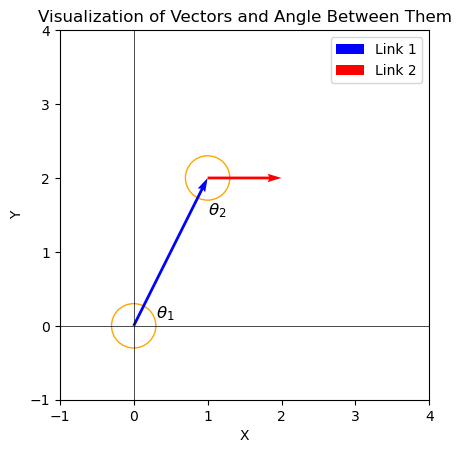

In [74]:
# The links and their x,y values
vector1 = np.array([1, 2])
vector2 = np.array([1, 0])

# Plotting the links
circle1 = plt.Circle((0, 0), radius=0.3, color='orange', fill=False)
circle2 = plt.Circle((vector1[0],vector1[1]), 0.3, color='orange', fill=False)

fig, ax = plt.subplots()
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.quiver(0, 0, vector1[0], vector1[1], angles='xy', scale_units='xy', scale=1, color='b', label='Link 1')
ax.quiver(1, 2, vector2[0], vector2[1], angles='xy', scale_units='xy', scale=1, color='r', label='Link 2')

# Angle labels
plt.text(0.3, 0.1, r'${\theta}_1$', fontsize=12)
plt.text(1, 1.5, r'${\theta}_2$', fontsize=12)


# Plot beautifying
plt.xlim(-1, 4)
plt.ylim(-1, 4)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Visualization of Vectors and Angle Between Them')
plt.axhline(0, color='k', linewidth=0.5)
plt.axvline(0, color='k', linewidth=0.5)

plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


So lets ignore the second link and ${\theta}_2$ making our robot a 1 ${dof}$ and look at the C-space (${C}$) of the first link for a second, pretty obviously it is $360{\degree}$ (a circle - ${S^1}$) and since mathematicians are evil we will use radians from now on and that means the configurations space is $2{\pi}$.

For 1 ${dof}$ robot  ${C_{1dof} = S^1}$

Now lets stop ignoring the second link and we get a C-space of 2 circles.

For 2 ${dof}$ robot  ${C_{2dof} = S^1 \cdot S^2}$

After pieceing up poor Robert we can see that his C-space describes a circle around another circle - donut (for the math nerds - a **torus**) in **2D** space with his 2${dof}$

![title](donut.png)

Source: https://en.wikipedia.org/wiki/Torus

How many ${dof}$ did he have in 3D space? Three so we get this:

For 3 ${dof}$ robot  ${C_{3dof} = S^1 \cdot S^2 \cdot S^3}$

This is a 3-dimensional torus - dont try to imagine it.

Execute the code below and try focusing on the angles and letting that sink in, the workspace of our friend is also shown but it doesn't concern us for now.

In [62]:
def rotate_vector(vector, angle_deg):
    # From degrees to radians
    angle_rad = math.radians(angle_deg)
    x, y = vector
    
    # Coordinates after rotation
    new_x = x * math.cos(angle_rad) - y * math.sin(angle_rad)
    new_y = x * math.sin(angle_rad) + y * math.cos(angle_rad)

    return new_x, new_y

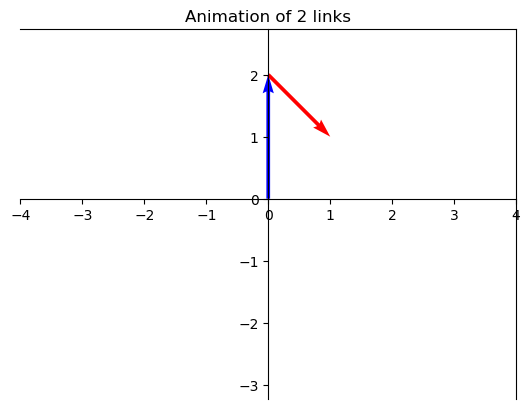

In [92]:
# Create a figure and a line object
fig, ax = plt.subplots()
vectors = np.array([[0.0,0.0,2.0,0.0], [0.0, 0.0, 1.0, 1.0]])
X, Y, U, V = vectors[:, 0], vectors[:, 1], vectors[:, 2], vectors[:, 3]
X, Y, U, V = vectors[:, 0], vectors[:, 1], vectors[:, 2], vectors[:, 3]
colors = [ 'blue','red']

for frame in range(90):
    U,V = rotate_vector([U, V], 5)
    # Assign second vector initial point
    X[1] = U[0]
    Y[1] = V[0]
    U[1],V[1] = rotate_vector([U[1], V[1]], 10)
    # Plotting
    line = ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', color=colors, scale=1)
    # Clearing for kind of animation
    ax.relim() 
    clear_output(wait=True)
    display(fig)
    ax.cla()

    # Make it nice
    ax.set_xlim([-4, 4])
    ax.set_ylim([-5.5, 5])
    ax.spines["bottom"].set_position("zero")
    ax.spines["left"].set_position("zero")
    ax.axis('equal')
    plt.title('Animation of 2 links')

plt.close()  # Close figure when done


### Disclaimer: for rotations and general movement its an industry standard to use matrices, for this perticular plot i used angles.

## Why is this important?

Before moving on to 3D and kinematics i feel like it's important to grasp the concept and understand the fundamentals of robotics. 
Our understanding of C-space is crucial for inverse kinematics, motion planing, collision detection and much more.


# 3. Kinematics

### Kinematics is a branch of physics that deals with motion, but without considering the force that realizes that movement. Fundamentally its about how fast something moves, how it speeds up and how fast it is. In our case it is pretty closelsy related to the end-effector position. To imagine it just move your fist in space and think about the speed, position and how much slower/faster you can move it.

There are some complicated kinematic stuff like trajectory planning and paths but i have no idea how to do that so we are gonna stick to the basics for now. Kinematics are very closely related to matrices, every link represents some kind of a translation matrix and every revolute joint represents a rotation matrix. How does this all come together? Since we are talking about 3D space **IN OUR CASE** we can represent every joint-link combo as seperate frames and a frame is essentialy a cartesian system which originates from the center of the joint. 

There are some rules for the frame assignments:

The $Z$ axes for revolute joints should correspond to the angle of rotation axes, note the MS Paint™ image below the $Z_1$ axis of the rotating base joint aligns with the axis of rotation, the same is true for both of the arm joints $Z_{2|3}$, as you can see they point to you. The $Z_4$ axis for our static gripper and ground $Z_0$ do not matter but since we can reduce some calculations if we match them up with the existing ones they correspond to the others as you can see.

The $X$ axes should point from the frame origin to the next joint, example - $X_2$ pointing towards the third joint. And if $Z$ axes intersect the $X$ one should be normal to the plane of the one before, note $Z_0$ and $Z_1$ and how $X_0$ and $X_1$ are paralell.

The $Y$ axes are set according to the right hand rule, point the thumb towards the $Z$ axis and the palm should point towards the $Y$.

Sorry for the terrible drawing :^)

Note the ${\theta_1}$ joint shown below, it is not between the ground and the first link, but between the first link and the second. In our case below it will be basically attached to the ground since we will not use that first joint, the joint that has length ${L_1}$ i have drawn it just for visualization purposes, otherwise the calculation for a joint that is not essentialy the ground is rather simple, just a translation along the ${Z_0}$ axis.

![title](FramesRobert.png)

### Denavit–Hartenberg parameters (DH parameters) - 4 parameters that describe how our frames are attached according to a convention. They are:
${d}$: offset along previous $Z$ to the common normal
${\theta}$: angle about previous $Z$ from old $X$ to new $X$ 

$r$: length of the common normal (aka $a$, but if using this notation, do not confuse with ${\alpha}$). Assuming a revolute joint, this is the radius about previous $Z$

${\alpha}$:  angle about common normal, from old $Z$ axis to new  $Z$ axis

With revolute and prismatic joints 3 of these parameters are always constants, for revolute joints the constant parameters are $d$,$r$ and $\alpha$ and for prismatic joints $\theta$, $r$ and $\alpha$.s

![title](params.png)

Source: https://prajankya.me/dh/

So how does a DH paramater table look, well like this:

<img src="table-example.jpg" alt="drawing" width="400"/>

Source: https://automaticaddison.com/homogeneous-transformation-matrices-using-denavit-hartenberg/

Lets try making one for our beautiful example. I will walk you through with joint $1$. 

First is the $d_1$ parameter, look at the normal axis - $X_{1|2}$ along the $Z_0$ axis and you get the length of $d_1$. 

Second the ${\alpha_1}$ angle, lets look again at the example, focusing on $Z_0$ and $Z_1$ along the $X_1$ axis, keep in mind that all axes continue infinitely, so $Z_0$ is going in the same direction as $Z_1$ - the angle is 0. Even in rotation of the joint the $Z_1$ axis remains the same.

Third one: $r_1$ - along $X_0$ look at the distance between $Z_0$ and $Z_1$, its 0 as well.

These were our constants, in revolute/prismatic joints there are always 3 constants and 1 variable.

Foruth one: $\theta_1$ - the angle between $X_0$ and $X_1$, in our example its 0 but consider the rotation of the second joint, $X_1$ will move along with it, so the angle is variable that we label $\theta_1$

| Joint i | ${\theta_i}$ (angle) | ${\alpha_i}$ (angle)     | $r_i$ (length)    | $d_i$ (length)    |
| :---    |    :----:            |     :---:                |         ---:      |          ---:     |
| 1       |   $\theta_1$         | 0                        | 0                 | $L1$              |
| 2       |   $\theta_2$         | ${90\degree}$            | 0                 | 0                 |
| 3       |   $\theta_3$         | 0                        | $L2$              | 0                 |
| 4       |   0                  | 0                        | $L3$              | 0                 |


Thats our DH table, you should be able to understand what the values mean and how are they calculated. Based on this table we will construct our transformation matrix for forward kinematics.

>

# 3.1. Forward Kinematics
### Used to obtain the end-effector position position from the parameters of the joints and links

To do that we must move from the first frame to the last frame, by applying the apporpirate transformations, a transformation from frame 0 to frame 1, from frame 1 to frame 2 etc. To find the transformation that describes going from frame $0$ to the end-effector frame $4$ we have to use this formula:

$\prescript{0}{n}{T} = \prescript{0}{1}{T}  \cdot  \prescript{1}{2}{T}  \cdot  \prescript{2}{3}{T} ... \prescript{n-1}{n}{T}$

And to get each transformation we use this one:

$\prescript{i-1}{i}{T} = R_x(\alpha_{i-1}) \cdot D_x(r_{i-1}) \cdot R_z(\theta_i) \cdot D_z(d_i)$

$R$ stands for rotation matrix and $D$ for translation.



In [3]:
def calculate_forward_kinematics(firstLength, secondLength, angleRotation, angleFirst, angleSecond):
    pass

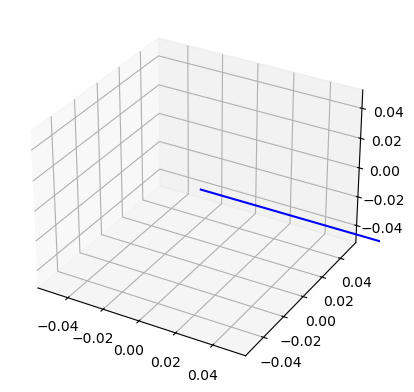

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to rotate a vector around the z-axis
def rotate_vector_3d(vector, angle):
    angle_rad = np.radians(angle)
    rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad), 0],
                                [np.sin(angle_rad), np.cos(angle_rad), 0],
                                [0, 0, 1]])
    return np.dot(rotation_matrix, vector)

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Initial vector
vector = np.array([1, 0, 0])

# Plot initial vector
ax.quiver(0, 0, 0, vector[0], vector[1], vector[2], color='b')

# Set plot limits
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

# Set plot labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Animation loop
for angle in range(0, 360, 5):
    ax.cla()  # Clear the axis
    rotated_vector = rotate_vector_3d(vector, angle)
    ax.quiver(0, 0, 0, rotated_vector[0], rotated_vector[1], rotated_vector[2], color='b')
    plt.pause(0.01)

plt.show()


Before moving to 3D and the fancy stuff, let's try something simpler. Let's plot an arm in 2D space.

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Increase the embed limit to allow larger animations
plt.rcParams['animation.embed_limit'] = 50  # Set limit to 50 MB

# Define the vectors
vectors = np.array([[0, 0, 0, -1, 1, 1], [-1, 1, 1, 1, 0.2, 0.2]])

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Function to update the view angle of the 3D plot
def update(num):
    ax.view_init(elev=10., azim=num)
    return ax,

# Plot the vectors
for vector in vectors:
    v = np.array([vector[3], vector[4], vector[5]])
    vlength = np.linalg.norm(v)
    ax.quiver(vector[0], vector[1], vector[2], vector[3], vector[4], vector[5])

# Set axis limits and labels
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_zlim([0, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.close()
# Create the animation
ani = FuncAnimation(fig, update, frames=36, interval=20, blit=False)

# Display the animation in Jupyter Notebook
HTML(ani.to_jshtml())
